In [ ]:
import argparse
import os
import sys
import shutil
import random
import numpy as np
import time
import copy
import math
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import gc
from torch.autograd import Variable
from transformers import GPT2TokenizerFast
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
cs461dir = '/content/drive/My Drive/Colab Notebooks/CS461/'

file_paths = ['wiki2.test.txt', 'wiki2.train.txt', 'wiki2.valid.txt']
if any(not os.path.exists(filepath) for filepath in file_paths):
  !cp -r "{cs461dir}"* /content/
  print("Files imported")

model_path = "./model_weights"
os.makedirs(model_path, exist_ok=True)

Mounted at /content/drive
Files imported


In [ ]:
def read_corpus(filename,tokenizer):
    seq = []
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = tokenizer(line)
            for t in tokens['input_ids']:
                seq.append(t)
    return(seq)

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x.int())

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 4096, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe = pe.cuda()
        x = x + pe
        return self.dropout(x)

class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention_dot_product(q, k, v, d_k, mask=None, dropout=None):

    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

def attention_Euclidean_distance(q, k, v, d_k, mask=None, dropout=None):

    scores = -torch.cdist(q, k, p=2)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):

        bs = q.size(0)

        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)


        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class CosineWithRestarts(torch.optim.lr_scheduler._LRScheduler):
    """
    Cosine annealing with restarts.

    Parameters
    ----------
    optimizer : torch.optim.Optimizer

    T_max : int
        The maximum number of iterations within the first cycle.

    eta_min : float, optional (default: 0)
        The minimum learning rate.

    last_epoch : int, optional (default: -1)
        The index of the last epoch.

    """

    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 T_max: int,
                 eta_min: float = 0.,
                 last_epoch: int = -1,
                 factor: float = 1.) -> None:
        # pylint: disable=invalid-name
        self.T_max = T_max
        self.eta_min = eta_min
        self.factor = factor
        self._last_restart: int = 0
        self._cycle_counter: int = 0
        self._cycle_factor: float = 1.
        self._updated_cycle_len: int = T_max
        self._initialized: bool = False
        super(CosineWithRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        """Get updated learning rate."""
        # HACK: We need to check if this is the first time get_lr() was called, since
        # we want to start with step = 0, but _LRScheduler calls get_lr with
        # last_epoch + 1 when initialized.
        if not self._initialized:
            self._initialized = True
            return self.base_lrs

        step = self.last_epoch + 1
        self._cycle_counter = step - self._last_restart

        lrs = [
            (
                self.eta_min + ((lr - self.eta_min) / 2) *
                (
                    np.cos(
                        np.pi *
                        ((self._cycle_counter) % self._updated_cycle_len) /
                        self._updated_cycle_len
                    ) + 1
                )
            ) for lr in self.base_lrs
        ]

        if self._cycle_counter % self._updated_cycle_len == 0:
            # Adjust the cycle length.
            self._cycle_factor *= self.factor
            self._cycle_counter = 0
            self._updated_cycle_len = int(self._cycle_factor * self.T_max)
            self._last_restart = step

        return lrs

# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

def forward_no_residual(self, x, mask):
  x2 = self.norm_1(x)
  x = x + self.dropout_1(self.attn_1(x2, x2, x2, mask))
  x2 = self.norm_2(x)
  x = self.dropout_2(self.ff(x2))
  return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, trg_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)
        self.out.weight = self.decoder.embed.embed.weight
    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

def get_model(opt, vocab_size):

    assert opt.d_model % opt.heads == 0
    assert opt.dropout < 1

    model = Transformer(vocab_size, opt.d_model, opt.n_layers, opt.heads, opt.dropout)
    model.to(opt.device)

    if opt.loadname is not None:
        print("loading pretrained weights...")
        model.load_state_dict(torch.load(opt.loadname))
    else:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    return model

In [ ]:
def train_model(model, opt):
    print("training model...")
    model.to(opt.device)
    model.train()

    # write code to:
    #  1. create a nopeak mask
    #  2. feed training data to the model in batches
    #  3. send the indices of training tokens to the GPU
    #  4. linearize the predictions and compute the loss against ground truth
    #     (you can use F.cross_entropy or write your own code)
    #  5. calculate and apply the gradients with loss.backward() and optimizer.step()
    #  6. report intermediate trainining perplexity
    #  7. generate a test perplexity once per training epoch by calling test_model()
    #  8. save model weights to file specified in opt.savename
    #  SEE trainer.py for examples of each of the above
    num_samples = len(opt.train)
    num_seqs = num_samples // opt.seqlen
    num_batches = num_seqs // opt.batchsize

    train_set = torch.tensor(opt.train[: num_seqs * opt.seqlen], dtype=torch.long)
    train_set = train_set.reshape(num_seqs, opt.seqlen)
    train_set = train_set.to(opt.device)

    mask = torch.tril(torch.ones(opt.seqlen - 1, opt.seqlen - 1), diagonal=0)
    mask = mask.unsqueeze(0).expand(opt.batchsize, opt.seqlen - 1, opt.seqlen - 1).to(opt.device)

    print(f"Training on {num_samples} samples - {num_seqs} sequences - with sequence length {opt.seqlen} and batch size {opt.batchsize}")

    train_loss = []
    val_loss = []
    best_val_perplexity = float("inf")

    optimizer = opt.optimizer

    for epoch in range(opt.epochs):
      total_loss = 0
      for i in range(num_batches):
        batch = train_set[i * opt.batchsize : (i + 1) * opt.batchsize]
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]
        optimizer.zero_grad()
        output = model(input_seq, mask)
        loss = F.cross_entropy(output.reshape(-1, opt.vocab_size), target_seq.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), opt.norm)
        optimizer.step()
        #if opt.SGDR:
        #  opt.sched.step()
        total_loss += loss.item()

      # track training and validation perplexity
      train_perplexity = torch.exp(torch.tensor(total_loss / num_batches))
      train_loss.append(train_perplexity)
      val_perplexity = test_model(model, opt, test_dataset = "valid")
      val_loss.append(val_perplexity)

      if opt.savename and val_perplexity < best_val_perplexity:
        best_val_perplexity = val_perplexity
        torch.save(model.state_dict(), os.path.join("./model_weights", opt.savename))

      print(f'Epoch: {epoch+1}/{opt.epochs} - Train Perplexity: {train_perplexity:.4f} - Valid Perplexity: {val_perplexity:.4f}')

    plt.plot(list(range(1, opt.epochs + 1)), train_loss, label='Training Perplexity')
    plt.plot(list(range(1, opt.epochs + 1)), val_loss, label='Validation Perplexity')
    plt.xticks(list(range(2, opt.epochs + 1, 2)))
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.title('Training and Validation Perplexity')
    plt.show()

    return

def test_model(model, opt, test_dataset = "valid"):
    print("testing model...")
    if test_dataset != "valid":
      model.to(opt.device)
    model.eval()

    # write code to generate perplexity of test set
    dataset = getattr(opt, test_dataset)
    num_samples = len(dataset)
    num_seqs = num_samples // opt.seqlen
    num_batches = num_seqs // opt.batchsize

    test_set = torch.tensor(dataset[: num_seqs * opt.seqlen], dtype=torch.long)
    test_set = test_set.reshape(num_seqs, opt.seqlen)
    test_set = test_set.to(opt.device)

    mask = torch.tril(torch.ones(opt.seqlen - 1, opt.seqlen - 1), diagonal=0)
    mask = mask.unsqueeze(0).expand(opt.batchsize, opt.seqlen - 1, opt.seqlen - 1).to(opt.device)

    total_loss = 0

    with torch.no_grad():
      for i in range(num_batches):
        batch = test_set[i * opt.batchsize : (i + 1) * opt.batchsize]
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]
        output = model(input_seq, mask)
        loss = F.cross_entropy(output.reshape(-1, opt.vocab_size), target_seq.reshape(-1))
        total_loss += loss.item()

    perplexity = torch.exp(torch.tensor(total_loss / num_batches))

    model.train()

    if test_dataset == "valid":
      return perplexity
    else:
      print(f"Test Perplexity: {perplexity:.4f}")
      return

Namespace(no_cuda=False, SGDR=False, epochs=20, d_model=512, n_layers=6, heads=8, dropout=0.1, batchsize=16, lr=1e-05, seqlen=512, savename='model.pth', loadname=None, norm=2.0, verbose=False, device=device(type='cuda'))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

total params: 44697169
training model...
Training on 2411664 samples - 4710 sequences - with sequence length 512 and batch size 16
testing model...
Epoch: 1/20 - Train Perplexity: 18512.8008 - Valid Perplexity: 7077.2939
testing model...
Epoch: 2/20 - Train Perplexity: 4425.2939 - Valid Perplexity: 1964.3445
testing model...
Epoch: 3/20 - Train Perplexity: 1743.3086 - Valid Perplexity: 874.0104
testing model...
Epoch: 4/20 - Train Perplexity: 1119.2086 - Valid Perplexity: 621.9969
testing model...
Epoch: 5/20 - Train Perplexity: 897.0673 - Valid Perplexity: 481.2557
testing model...
Epoch: 6/20 - Train Perplexity: 743.3868 - Valid Perplexity: 395.6980
testing model...
Epoch: 7/20 - Train Perplexity: 645.4501 - Valid Perplexity: 349.0714
testing model...
Epoch: 8/20 - Train Perplexity: 582.8170 - Valid Perplexity: 320.6857
testing model...
Epoch: 9/20 - Train Perplexity: 537.8292 - Valid Perplexity: 300.6859
testing model...
Epoch: 10/20 - Train Perplexity: 501.3138 - Valid Perplexity: 

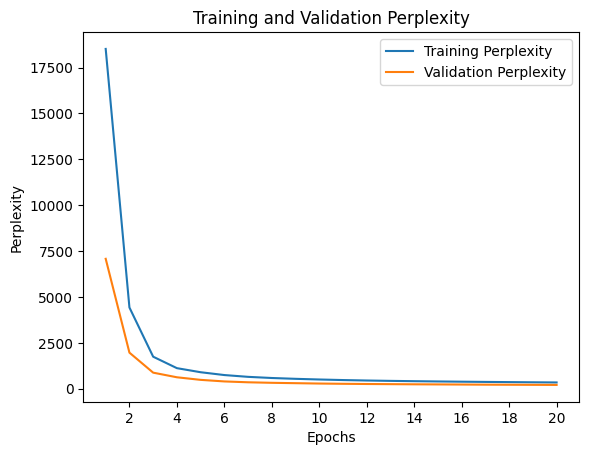

loading pretrained weights...
testing model...


<ipython-input-2-6a02b91533e8>:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(opt.loadname))


Test Perplexity: 181.1588


In [ ]:
def main():

    random.seed(10)

    parser = argparse.ArgumentParser()
    parser.add_argument('-no_cuda', action='store_true')
    parser.add_argument('-SGDR', action='store_true')
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-d_model', type=int, default=512)
    parser.add_argument('-n_layers', type=int, default=6)
    parser.add_argument('-heads', type=int, default=8)
    parser.add_argument('-dropout', type=float, default=0.1)
    parser.add_argument('-batchsize', type=int, default=16)
    parser.add_argument('-lr', type=float, default=0.00001)
    parser.add_argument('-seqlen', type=int, default=512)
    parser.add_argument('-savename', type=str, default="model.pth")
    parser.add_argument('-loadname', type=str)
    parser.add_argument('-norm', type=float, default=2.0)

    if "google.colab" in sys.modules:
      sys.argv = ["notebook"]

    opt = parser.parse_args()
    opt.verbose = False

    opt.device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")

    print(str(opt))

    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    opt.train = read_corpus('wiki2.train.txt',tokenizer)
    opt.valid = read_corpus('wiki2.valid.txt',tokenizer)
    opt.test = read_corpus('wiki2.test.txt',tokenizer)

    obs = len(opt.train)
    opt.vocab_size = 50257

    model = get_model(opt,opt.vocab_size)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    text = 'total params: %d' % (params)
    print(text)

    opt.optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.98), eps=1e-9)

    # Set an empirical T_max
    '''
    num_train_samples = len(opt.train)
    num_train_seqs = num_train_samples // opt.seqlen
    opt.train_len = num_train_seqs // opt.batchsize
    if opt.SGDR == True:
      opt.sched = CosineWithRestarts(opt.optimizer, T_max=opt.train_len)
    '''

    train_model(model, opt)

    # save a copy to drive
    shutil.copy(os.path.join("./model_weights", opt.savename), cs461dir)

    opt.loadname = "./model_weights/" + opt.savename
    model_retrieved = get_model(opt, opt.vocab_size)
    test_model(model_retrieved, opt, "test")

if __name__ == "__main__":
  attention = attention_dot_product
  main()

Namespace(no_cuda=False, SGDR=False, epochs=20, d_model=512, n_layers=6, heads=8, dropout=0.1, batchsize=16, lr=1e-05, seqlen=512, savename='model_q3.pth', loadname=None, norm=2.0, verbose=False, device=device(type='cuda'))
total params: 44697169
training model...
Training on 2411664 samples - 4710 sequences - with sequence length 512 and batch size 16
testing model...
Epoch: 1/20 - Train Perplexity: 18594.6523 - Valid Perplexity: 7156.2407
testing model...
Epoch: 2/20 - Train Perplexity: 4456.3032 - Valid Perplexity: 1986.0387
testing model...
Epoch: 3/20 - Train Perplexity: 1753.5132 - Valid Perplexity: 891.5373
testing model...
Epoch: 4/20 - Train Perplexity: 1118.0011 - Valid Perplexity: 623.7003
testing model...
Epoch: 5/20 - Train Perplexity: 893.7890 - Valid Perplexity: 485.0037
testing model...
Epoch: 6/20 - Train Perplexity: 744.6154 - Valid Perplexity: 396.5238
testing model...
Epoch: 7/20 - Train Perplexity: 646.0406 - Valid Perplexity: 347.9733
testing model...
Epoch: 8/20 

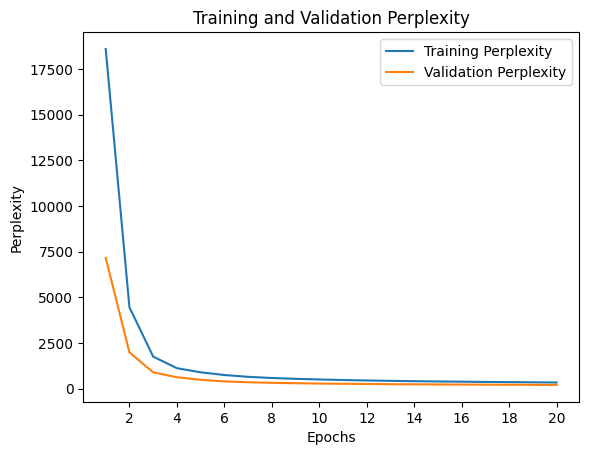

loading pretrained weights...
testing model...


<ipython-input-2-6a02b91533e8>:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(opt.loadname))


Test Perplexity: 178.5659


In [ ]:
gc.collect()
torch.cuda.empty_cache()
def main():

    random.seed(10)

    parser = argparse.ArgumentParser()
    parser.add_argument('-no_cuda', action='store_true')
    parser.add_argument('-SGDR', action='store_true')
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-d_model', type=int, default=512)
    parser.add_argument('-n_layers', type=int, default=6)
    parser.add_argument('-heads', type=int, default=8)
    parser.add_argument('-dropout', type=float, default=0.1)
    parser.add_argument('-batchsize', type=int, default=16)
    parser.add_argument('-lr', type=float, default=0.00001)
    parser.add_argument('-seqlen', type=int, default=512)
    parser.add_argument('-savename', type=str, default="model_q3.pth")
    parser.add_argument('-loadname', type=str)
    parser.add_argument('-norm', type=float, default=2.0)

    if "google.colab" in sys.modules:
      sys.argv = ["notebook"]

    opt = parser.parse_args()
    opt.verbose = False
    opt.loadname = None

    opt.device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")

    print(str(opt))

    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    opt.train = read_corpus('wiki2.train.txt',tokenizer)
    opt.valid = read_corpus('wiki2.valid.txt',tokenizer)
    opt.test = read_corpus('wiki2.test.txt',tokenizer)

    obs = len(opt.train)
    opt.vocab_size = 50257

    model = get_model(opt,opt.vocab_size)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    text = 'total params: %d' % (params)
    print(text)

    opt.optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.98), eps=1e-9)

    # Set an empirical T_max
    '''
    num_train_samples = len(opt.train)
    num_train_seqs = num_train_samples // opt.seqlen
    opt.train_len = num_train_seqs // opt.batchsize
    if opt.SGDR == True:
      opt.sched = CosineWithRestarts(opt.optimizer, T_max=opt.train_len)
    '''

    train_model(model, opt)

    # save a copy to drive
    shutil.copy(os.path.join("./model_weights", opt.savename), cs461dir)

    opt.loadname = "./model_weights/" + opt.savename
    model_retrieved = get_model(opt, opt.vocab_size)
    test_model(model_retrieved, opt, "test")

if __name__ == "__main__":
  attention = attention_Euclidean_distance
  main()

Namespace(no_cuda=False, SGDR=False, epochs=20, d_model=512, n_layers=6, heads=8, dropout=0.1, batchsize=16, lr=1e-05, seqlen=512, savename='model_q4.pth', loadname=None, norm=2.0, verbose=False, device=device(type='cuda'))
total params: 44697169
training model...
Training on 2411664 samples - 4710 sequences - with sequence length 512 and batch size 16
testing model...
Epoch: 1/20 - Train Perplexity: 19721.7578 - Valid Perplexity: 7099.5957
testing model...
Epoch: 2/20 - Train Perplexity: 4928.5449 - Valid Perplexity: 1985.7566
testing model...
Epoch: 3/20 - Train Perplexity: 1952.6449 - Valid Perplexity: 942.8327
testing model...
Epoch: 4/20 - Train Perplexity: 1228.5663 - Valid Perplexity: 676.6662
testing model...
Epoch: 5/20 - Train Perplexity: 1000.1827 - Valid Perplexity: 528.4945
testing model...
Epoch: 6/20 - Train Perplexity: 850.3576 - Valid Perplexity: 447.7648
testing model...
Epoch: 7/20 - Train Perplexity: 750.8470 - Valid Perplexity: 391.4001
testing model...
Epoch: 8/20

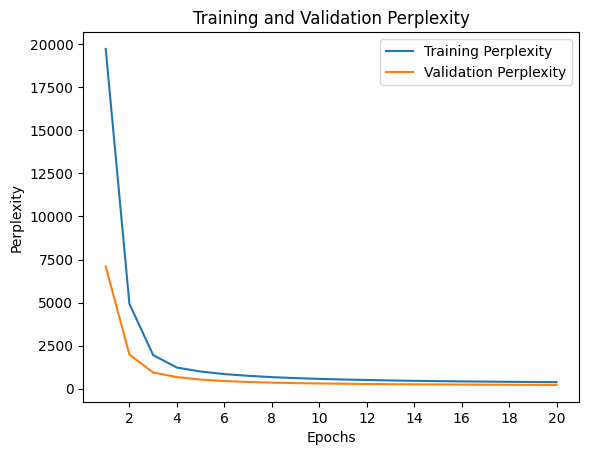

loading pretrained weights...
testing model...


<ipython-input-2-6a02b91533e8>:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(opt.loadname))


Test Perplexity: 194.3332


In [6]:
gc.collect()
torch.cuda.empty_cache()
def main():

    random.seed(10)

    parser = argparse.ArgumentParser()
    parser.add_argument('-no_cuda', action='store_true')
    parser.add_argument('-SGDR', action='store_true')
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-d_model', type=int, default=512)
    parser.add_argument('-n_layers', type=int, default=6)
    parser.add_argument('-heads', type=int, default=8)
    parser.add_argument('-dropout', type=float, default=0.1)
    parser.add_argument('-batchsize', type=int, default=16)
    parser.add_argument('-lr', type=float, default=0.00001)
    parser.add_argument('-seqlen', type=int, default=512)
    parser.add_argument('-savename', type=str, default="model_q4.pth")
    parser.add_argument('-loadname', type=str)
    parser.add_argument('-norm', type=float, default=2.0)

    if "google.colab" in sys.modules:
      sys.argv = ["notebook"]

    opt = parser.parse_args()
    opt.verbose = False
    opt.loadname = None

    opt.device = torch.device("cuda" if torch.cuda.is_available() and not opt.no_cuda else "cpu")

    print(str(opt))

    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    opt.train = read_corpus('wiki2.train.txt',tokenizer)
    opt.valid = read_corpus('wiki2.valid.txt',tokenizer)
    opt.test = read_corpus('wiki2.test.txt',tokenizer)

    obs = len(opt.train)
    opt.vocab_size = 50257

    model = get_model(opt,opt.vocab_size)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    text = 'total params: %d' % (params)
    print(text)

    opt.optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.98), eps=1e-9)

    # Set an empirical T_max
    '''
    num_train_samples = len(opt.train)
    num_train_seqs = num_train_samples // opt.seqlen
    opt.train_len = num_train_seqs // opt.batchsize
    if opt.SGDR == True:
      opt.sched = CosineWithRestarts(opt.optimizer, T_max=opt.train_len)
    '''

    train_model(model, opt)

    # save a copy to drive
    shutil.copy(os.path.join("./model_weights", opt.savename), cs461dir)

    opt.loadname = "./model_weights/" + opt.savename
    model_retrieved = get_model(opt, opt.vocab_size)
    test_model(model_retrieved, opt, "test")

if __name__ == "__main__":
  attention = attention_dot_product
  DecoderLayer.forward = forward_no_residual
  main()